In [123]:
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import requests

from time import sleep

from collections import Counter
from matplotlib.gridspec import GridSpec

from sklearn import linear_model
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler


Opciones globales

In [124]:
# global settings for pandas.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('mode.chained_assignment', None)
pd.options.display.float_format = '{:.2f}'.format

# global settings for seaborn.
# sns.set_theme(style="whitegrid")
plt.style.use('seaborn')

Funciones globales

In [125]:
def describe_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Dado un DataFrame {df}, devuelve otro DataFrame con datos descriptivos
    según las medidas especificadas en el diccionario {measures}.
    """
    measures = {
        'Cardinality': df.nunique(), 
        'Null': df.shape[0] - df.count(), 
        '% Null': round((df.shape[0] - df.count()) / df.shape[0] * 100, 3),
        'Non-Null': df.count(), 
        '% Non-Null': round(df.count() / df.shape[0] * 100, 3), 
        'Types': df.dtypes,
        'Size (mb)': df.memory_usage() / 1000000
    }    
    return pd.DataFrame(index=df.columns, data=measures)

def correlation_df(df):
    plt.figure(figsize=(16, 6))
    ax = sns.heatmap(df.corr(),vmin=-1, vmax=1, annot=True)
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    
def fill_na_by(row, by_field, filter_field, lower_map, upper_map):
    """
    Permite rellenar con np.nan a un campo numérico del DataFrame en función de un intervalo definido por series.
    """
    
    if np.isnan(row[filter_field]):
        return np.nan
    
    lower_threshold = lower_map.loc[row[by_field]]
    upper_threshold = upper_map.loc[row[by_field]]
    
    return row[filter_field] if row[filter_field] >= lower_threshold and row[filter_field] <= upper_threshold else np.nan

def entrenar_plotear(x_original, y_original, alpha):
    x_original = x_original.to_numpy()
    y_original = y_original.to_numpy()
    # Split
    xo_train,xo_val,yo_train,yo_val = train_test_split(x_original,y_original,test_size=0.30,random_state=25)
    # print(xo_train.shape,xo_val.shape,yo_train.shape,yo_val.shape)
    # Pipeslines
    pipline_lr_std = Pipeline([
        ('standarizacion',StandardScaler()),
        ('modelo',LinearRegression())
    ])
    pipline_lr_SIN_std = Pipeline([
        ('modelo',LinearRegression())
    ])
    pipline_Enet_std_1 = Pipeline([
        ('standarizacion',StandardScaler()),
        ('modelo',ElasticNet(l1_ratio=1,alpha=alpha,max_iter=10000))
    ])
    pipline_Enet_std_05 = Pipeline([
        ('standarizacion',StandardScaler()),
        ('modelo',ElasticNet(l1_ratio=0.5,alpha=alpha,max_iter=10000))
    ])
    pipline_Enet_std_0 = Pipeline([
        ('standarizacion',StandardScaler()),
        ('modelo',ElasticNet(l1_ratio=0,alpha=alpha,max_iter=10000))
    ])
    pipelines = [pipline_lr_std,pipline_lr_SIN_std,pipline_Enet_std_1,pipline_Enet_std_05,pipline_Enet_std_0]
    names = ['pipline_lr_std','pipline_lr_SIN_std','pipline_Enet_std_1','pipline_Enet_std_05','pipline_Enet_std_0']
    # Ploteo
    plt.figure(figsize=(15,10))
    k=3
    plt.subplots_adjust(bottom=1.5*k,top=2*k)
    for s,p in enumerate(pipelines):
        # print(s)
        # Entrenamiento
        p.fit(xo_train,yo_train)
        y_pred = p.predict(xo_val)
        # Resultados
        y_r2_score = r2_score(yo_val,y_pred)
        rmae = mean_squared_error(yo_val,y_pred)**0.5
        # Conf ploteo
        plt.subplot(3,2,s+1)
        plt.plot(yo_val,yo_val,'bo')
        plt.plot(yo_val,y_pred,'ro',alpha=0.25)
        plt.title('{0} R2 Score: {1} RMAE: {2}'.format(names[s],y_r2_score.round(3),rmae.round(3)))
        #plt.axis([yo_val.min()*1.1,yo_val.max()*1.1,yo_val.min()*1.1,yo_val.max()*1.1])        
    plt.show()
    
def entrenar (X, y, plotear=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)    
    if plotear:
        plt.plot(y,y, '-.',c='grey')
        plt.scatter(y_pred, y_test, s=30, c='r', marker='o', zorder=10)
    print ("EMC:", mean_squared_error(y_test, y_pred)) 
    print ("R2:", linreg.score(X, y))  
    return linreg, y_pred

def borrar_outliers(df, columna):
    q_low = df[columna].quantile(0.25)
    q_hi  = df[columna].quantile(0.75)
    IQR = (q_hi - q_low)*1.5
    lim_low = q_low - IQR
    lim_sup = q_hi + IQR
    df_sin_out = df[(df[columna] < lim_sup) & (df[columna] > lim_low)]
    
    eliminados = df.shape[0] - df_sin_out.shape[0]
    
    print (f"Se filtraron {eliminados} resultados")
    try:
        print (f"{(eliminados/df_sin_out.shape[0])*100}% de los que habia")
    except:
        pass
    return df_sin_out

Datos originales

In [126]:
o_data = pd.read_csv(filepath_or_buffer='df_exploratory.csv')

### Descripción de datos

Revisión gráfica de los datos de la etapa anterior para identificar puntos a tener en cuente.

#### STORE

<AxesSubplot:>

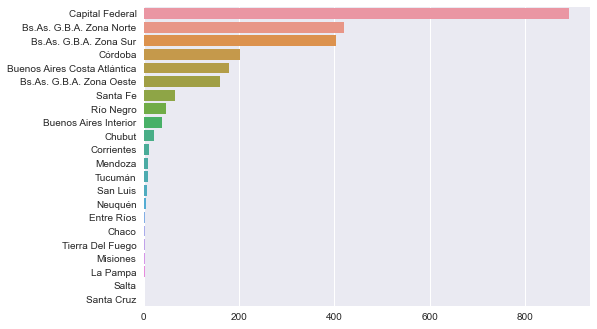

In [127]:
sns.barplot(
    y=o_data.loc[o_data['property_type'] == 'store']['state_name'].value_counts().index, 
    x=o_data.loc[o_data['property_type'] == 'store']['state_name'].value_counts().values, 
    orient='h'
)

In [128]:
describe_df(o_data.loc[o_data['property_type'] == 'store'])

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
property_type,1,0,0.00,2488,100.00,object,0.02
state_name,22,0,0.00,2488,100.00,object,0.02
place_name,253,0,0.00,2488,100.00,object,0.02
lat,1362,2,0.08,2486,99.92,float64,0.02
lon,1361,2,0.08,2486,99.92,float64,0.02
price_aprox_usd,460,0,0.00,2488,100.00,float64,0.02
surface_total_in_m2,420,129,5.18,2359,94.81,float64,0.02
surface_covered_in_m2,392,152,6.11,2336,93.89,float64,0.02
price_usd_per_m2,1532,0,0.00,2488,100.00,float64,0.02
rooms,6,2184,87.78,304,12.22,float64,0.02


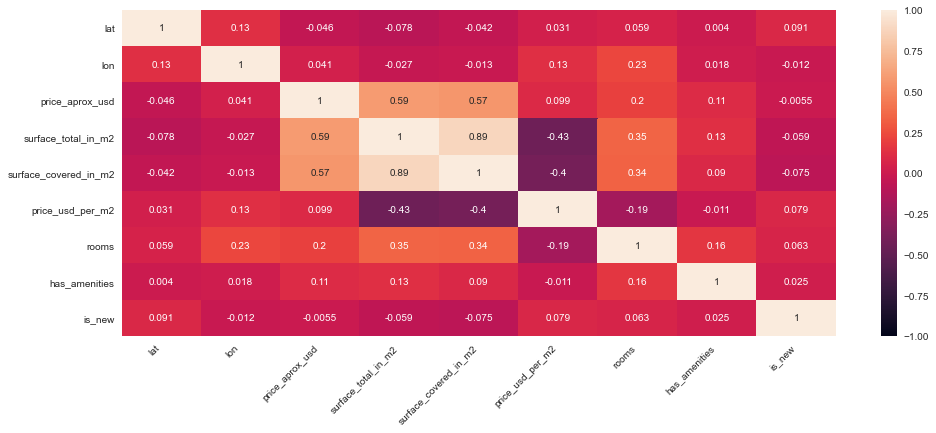

In [129]:
correlation_df(o_data.loc[o_data['property_type'] == 'store'])

#### APARTMENT

In [130]:
describe_df(o_data.loc[o_data['property_type'] == 'apartment'])

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
property_type,1,0,0.00,49811,100.00,object,0.40
state_name,25,0,0.00,49811,100.00,object,0.40
place_name,434,0,0.00,49811,100.00,object,0.40
lat,18032,6,0.01,49805,99.99,float64,0.40
lon,18010,6,0.01,49805,99.99,float64,0.40
price_aprox_usd,7918,0,0.00,49811,100.00,float64,0.40
surface_total_in_m2,220,1811,3.64,48000,96.36,float64,0.40
surface_covered_in_m2,145,1390,2.79,48421,97.21,float64,0.40
price_usd_per_m2,17564,0,0.00,49811,100.00,float64,0.40
rooms,6,7462,14.98,42349,85.02,float64,0.40


<AxesSubplot:>

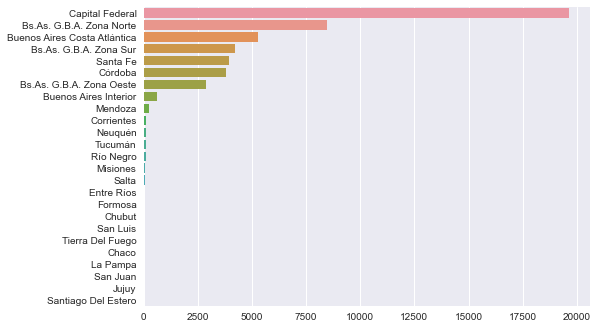

In [131]:
sns.barplot(
    y=o_data.loc[o_data['property_type'] == 'apartment']['state_name'].value_counts().index, 
    x=o_data.loc[o_data['property_type'] == 'apartment']['state_name'].value_counts().values, 
    orient='h'
)

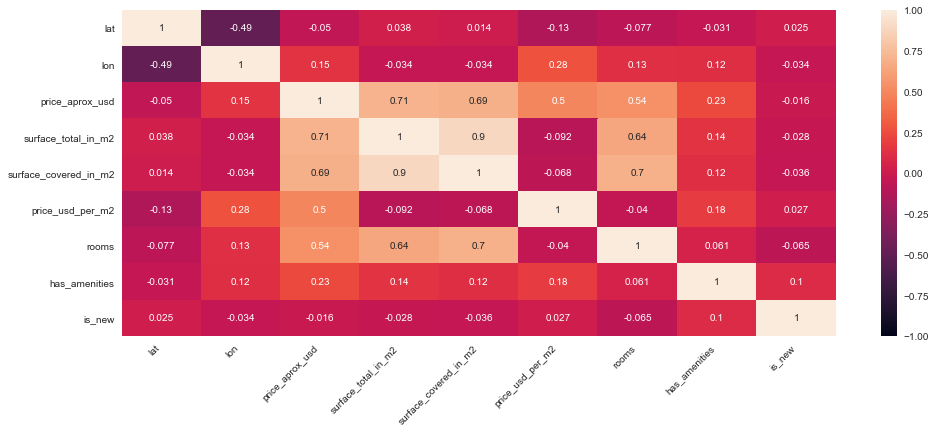

In [132]:
correlation_df(o_data.loc[o_data['property_type'] == 'apartment'])

#### PH

In [133]:
describe_df(o_data.loc[o_data['property_type'] == 'PH'])

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
property_type,1,0,0.00,4265,100.00,object,0.03
state_name,15,0,0.00,4265,100.00,object,0.03
place_name,249,0,0.00,4265,100.00,object,0.03
lat,2654,2,0.05,4263,99.95,float64,0.03
lon,2655,2,0.05,4263,99.95,float64,0.03
price_aprox_usd,398,0,0.00,4265,100.00,float64,0.03
surface_total_in_m2,215,169,3.96,4096,96.04,float64,0.03
surface_covered_in_m2,170,136,3.19,4129,96.81,float64,0.03
price_usd_per_m2,2180,0,0.00,4265,100.00,float64,0.03
rooms,7,614,14.40,3651,85.60,float64,0.03


<AxesSubplot:>

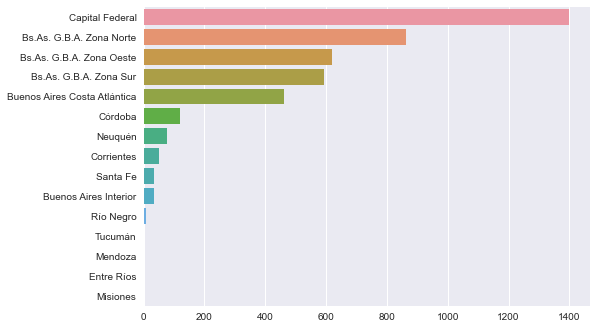

In [134]:
sns.barplot(
    y=o_data.loc[o_data['property_type'] == 'PH']['state_name'].value_counts().index, 
    x=o_data.loc[o_data['property_type'] == 'PH']['state_name'].value_counts().values, 
    orient='h'
)

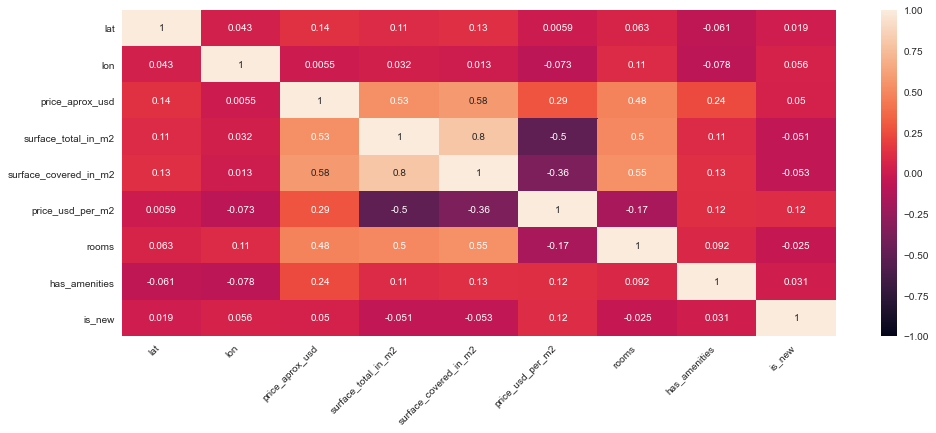

In [135]:
correlation_df(o_data.loc[o_data['property_type'] == 'PH'])

#### HOUSE

In [136]:
describe_df(o_data.loc[o_data['property_type'] == 'house'])

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
property_type,1,0,0.00,26941,100.00,object,0.22
state_name,27,0,0.00,26941,100.00,object,0.22
place_name,839,0,0.00,26941,100.00,object,0.22
lat,12085,28,0.10,26913,99.90,float64,0.22
lon,12076,28,0.10,26913,99.90,float64,0.22
price_aprox_usd,1048,0,0.00,26941,100.00,float64,0.22
surface_total_in_m2,830,1883,6.99,25058,93.01,float64,0.22
surface_covered_in_m2,487,794,2.95,26147,97.05,float64,0.22
price_usd_per_m2,10303,0,0.00,26941,100.00,float64,0.22
rooms,9,10705,39.73,16236,60.27,float64,0.22


<AxesSubplot:>

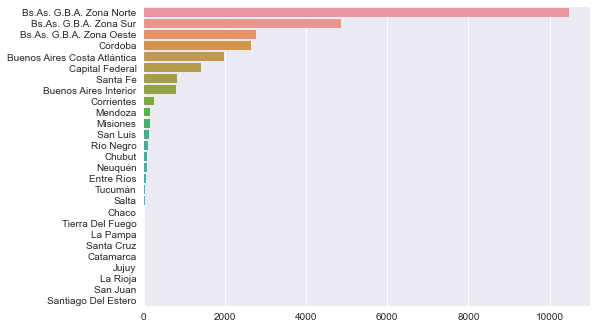

In [137]:
sns.barplot(
    y=o_data.loc[o_data['property_type'] == 'house']['state_name'].value_counts().index, 
    x=o_data.loc[o_data['property_type'] == 'house']['state_name'].value_counts().values, 
    orient='h'
)

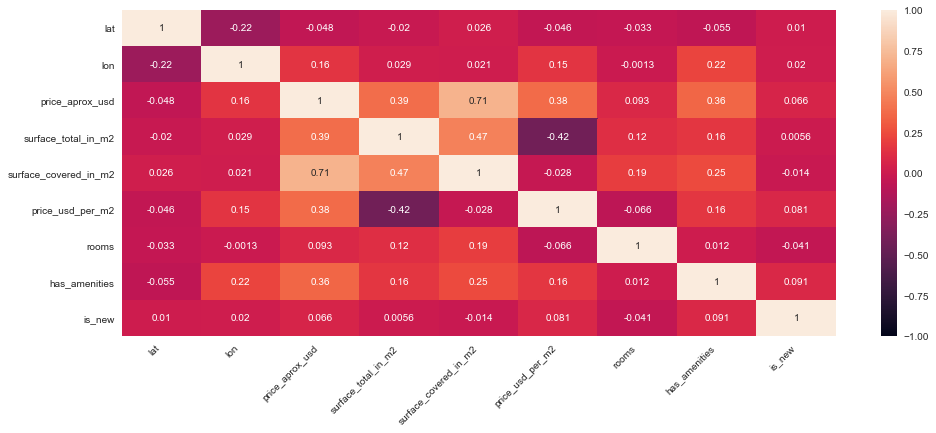

In [138]:
correlation_df(o_data.loc[o_data['property_type'] == 'house'])

# CAPITAL FEDERAL

In [139]:
# filtrado por capital.
df_capital = o_data.copy()
df_capital = df_capital[df_capital.state_name=="Capital Federal"]

# completar faltantes de ambientes.
df_capital.loc[df_capital.property_type == "house"].rooms.fillna(df_capital.rooms.mean().round(), inplace=True)
df_capital.loc[df_capital.property_type == "PH"].rooms.fillna(df_capital.rooms.mean().round(), inplace=True)
df_capital.loc[df_capital.property_type == "apartment"].rooms.fillna(df_capital.rooms.mean().round(), inplace=True)

# filtrar outliers.
df_capital = borrar_outliers(df_capital, "surface_total_in_m2")
df_capital = borrar_outliers(df_capital, "price_usd_per_m2")
df_capital = df_capital.loc[df_capital.rooms < 5]

# transformar variables categóricas.
capital_dummies = pd.get_dummies(df_capital, columns=["property_type", "place_name"])


Se filtraron 2405 resultados
11.488487627782556% de los que habia
Se filtraron 502 resultados
2.456930305403289% de los que habia


EMC: 1068506634.2148594
R2: 0.7459750569460538


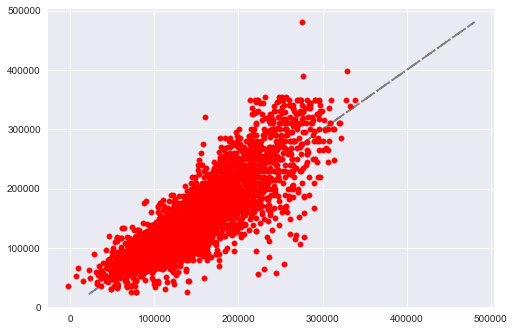

In [140]:
# variables explicativas.
X = capital_dummies[["is_new", "has_amenities", 'rooms', "surface_total_in_m2", 
       'place_name_Agronomía', 'place_name_Almagro', 'place_name_Balvanera',
       'place_name_Barracas', 'place_name_Barrio Norte', 'place_name_Belgrano',
       'place_name_Boca', 'place_name_Boedo', 'place_name_Caballito',
       'place_name_Capital Federal', 'place_name_Centro / Microcentro',
       'place_name_Chacarita', 'place_name_Coghlan', 'place_name_Colegiales',
       'place_name_Congreso', 'place_name_Constitución', 'place_name_Flores',
       'place_name_Floresta', 'place_name_Las Cañitas', 'place_name_Liniers',
       'place_name_Mataderos', 'place_name_Monserrat',
       'place_name_Monte Castro', 'place_name_Nuñez', 'place_name_Once',
       'place_name_Palermo', 'place_name_Palermo Chico',
       'place_name_Palermo Hollywood', 'place_name_Palermo Soho',
       'place_name_Palermo Viejo', 'place_name_Parque Avellaneda',
       'place_name_Parque Centenario', 'place_name_Parque Chacabuco',
       'place_name_Parque Chas', 'place_name_Parque Patricios',
       'place_name_Paternal', 'place_name_Pompeya', 'place_name_Puerto Madero',
       'place_name_Recoleta', 'place_name_Retiro', 'place_name_Saavedra',
       'place_name_San Cristobal', 'place_name_San Nicolás',
       'place_name_San Telmo', 'place_name_Tribunales',
       'place_name_Velez Sarsfield', 'place_name_Versalles',
       'place_name_Villa Crespo', 'place_name_Villa Devoto',
       'place_name_Villa General Mitre', 'place_name_Villa Lugano',
       'place_name_Villa Luro', 'place_name_Villa Ortuzar',
       'place_name_Villa Pueyrredón', 'place_name_Villa Real',
       'place_name_Villa Riachuelo', 'place_name_Villa Santa Rita',
       'place_name_Villa Soldati', 'place_name_Villa Urquiza',
       'place_name_Villa del Parque']]

# variable a predecir.
y = capital_dummies["price_aprox_usd"]

# entrenar modelo.
model, predictions = entrenar(X, y, True)

In [141]:
cv = cross_validate(model, X, y, cv=20)

print (f"El cross validation con 20 iteraciones da: {cv['test_score'].mean()}")

El cross validation con 20 iteraciones da: 0.7375533582469873


# INTERIOR

In [142]:
# filtrar interior.
df_interior = o_data.copy()
filtrar_interior = ['Capital Federal', 'Buenos Aires Costa Atlántica', 'Bs.As. G.B.A. Zona Norte',
                    'Bs.As. G.B.A. Zona Oeste', 'Bs.As. G.B.A. Zona Sur'] # , 'Buenos Aires Interior'
df_interior = df_interior[np.logical_not(o_data.state_name.isin(filtrar_interior))]

# completar cantidad de ambientes.
df_interior.loc[df_interior.property_type == "house"].rooms.fillna(df_interior.rooms.mean().round(), inplace=True)
df_interior.loc[df_interior.property_type == "PH"].rooms.fillna(df_interior.rooms.mean().round(), inplace=True)
df_interior.loc[df_interior.property_type == "apartment"].rooms.fillna(df_interior.rooms.mean().round(), inplace=True)

# transformar variables categóricas.
df_interior_dummies = pd.get_dummies(df_interior, columns=["property_type", "state_name", "place_name"]).dropna()

# borrar outliers.
df_interior_dummies = borrar_outliers(df_interior_dummies, "price_aprox_usd")
df_interior_dummies = borrar_outliers(df_interior_dummies, "surface_total_in_m2")

Se filtraron 658 resultados
7.992226405927365% de los que habia
Se filtraron 1055 resultados
14.697687378099749% de los que habia


EMC: 894672398.8091947
R2: 0.4175026339489767


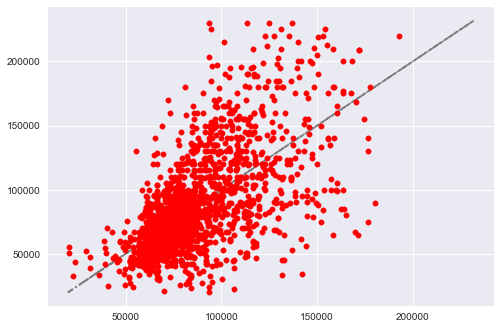

In [143]:
# variables explicativas.
X = df_interior_dummies[['surface_total_in_m2','rooms', 'has_amenities',
       'is_new', 'property_type_PH', 'property_type_apartment',
       'property_type_house', 'property_type_store', 'state_name_Catamarca',
       'state_name_Chaco', 'state_name_Chubut', 'state_name_Corrientes',
       'state_name_Córdoba', 'state_name_Entre Ríos', 'state_name_Formosa',
       'state_name_Jujuy', 'state_name_La Pampa', 'state_name_La Rioja',
       'state_name_Mendoza', 'state_name_Misiones', 'state_name_Neuquén',
       'state_name_Río Negro', 'state_name_Salta', 'state_name_San Juan',
       'state_name_San Luis', 'state_name_Santa Cruz', 'state_name_Santa Fe',
       'state_name_Santiago Del Estero', 'state_name_Tierra Del Fuego',
       'state_name_Tucumán']]

# variable a predecir.
y = df_interior_dummies["price_aprox_usd"]

# entrenar modelo.
model, predictions = entrenar(X, y, plotear=True)

In [144]:
# validación del modelo.
cv = cross_validate(model, X, y, cv=20)
print (f"El cross validation con 20 iteraciones da: {cv['test_score'].mean()}")

El cross validation con 20 iteraciones da: 0.3901993975460889


# GBA + COSTA ATLÁNTICA

### BUENOS AIRES

Se copian los datos originales y se filtra por las zonas correspondientes a Buenos Aires.

In [145]:
gba_data = o_data.copy()
gba_data = gba_data.loc[gba_data['state_name'].isin(['Buenos Aires Costa Atlántica', 'Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Oeste', 'Bs.As. G.B.A. Zona Sur'])]

Visualizar cuartiles.

<AxesSubplot:xlabel='property_type', ylabel='price_aprox_usd'>

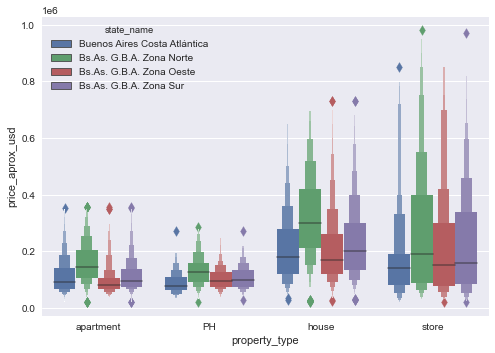

In [146]:
sns.boxenplot(y='price_aprox_usd',  x='property_type', hue='state_name', data=gba_data, orient='v')

Visualizar observaciones.

<AxesSubplot:xlabel='property_type', ylabel='price_aprox_usd'>

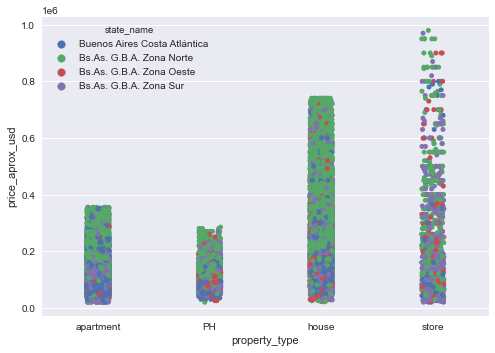

In [147]:
sns.stripplot(y='price_aprox_usd',  x='property_type', hue='state_name', data=gba_data, orient='v')

Para reducir la dimensionalidad del campo **place_name** se busca para cada par de coordenadas el municipio al cual corresponde. Esto se hace mediante llamados a la api pública https://datosgobar.github.io/georef-ar-api, para simplificar el código y aumentar la portabilidad se leen las respuestas desde el archivo JSON *responses.json*.

In [148]:
# concatenar coordenadas en un string separado por '&'.
gba_data['lat-lon'] = gba_data.apply(lambda x: f'{round(x.lat,2)}&{round(x.lon,2)}', axis=1)

# leer respuestas.
with open('responses.json') as f:
    responses = json.loads(f.read())
    
# armar diccionario de coordenadas y municipios.
lat_lon_map = dict()
for response in responses:
    if not response:
        continue
    for result in response['resultados']:
        lat_lon_map[f"{result['ubicacion']['lat']}&{result['ubicacion']['lon']}"] = result['ubicacion']

# nueva columna municipio a partir de las coordenadas.
gba_data['municipio'] = gba_data.apply(lambda x: lat_lon_map.get(x['lat-lon'], np.nan).get('municipio_nombre') if lat_lon_map.get(x['lat-lon']) is not None else np.nan, axis=1)

Cada *municipio* se transforma a variable continua mediante un proceso de pseudo-estandarización.  

In [149]:
# transformación logarítmica del precio promedio del municipio dividido el precio promedio de la zona (por property_type).
ppm_muni_std = np.log(gba_data.groupby(by=['state_name', 'property_type', 'municipio'])['price_usd_per_m2'].mean() / gba_data.groupby(by=['state_name', 'property_type'])['price_usd_per_m2'].mean())
ppm_muni_std_mean = ppm_muni_std.mean()

gba_data['ppm_municipio'] = gba_data.apply(
    lambda x: ppm_muni_std.loc[(x.state_name, x.property_type, x.municipio)] if x.municipio not in (None, np.nan) else ppm_muni_std_mean, 
    axis=1)

<AxesSubplot:xlabel='ppm_municipio'>

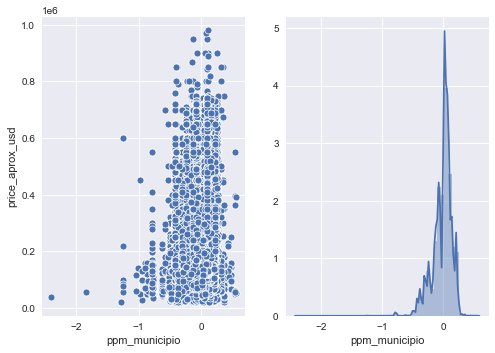

In [150]:
f, (ax0, ax1) = plt.subplots(1, 2)
sns.scatterplot(x='ppm_municipio', y='price_aprox_usd', data=gba_data, ax=ax0)
sns.distplot(gba_data['ppm_municipio'], ax=ax1)

In [151]:
# transformación logarítmica del precio promedio de la zona dividido el precio promedio del tipo de propiedad.
ppm_zone_std = np.log(gba_data.groupby(by=['property_type', 'state_name'])['price_usd_per_m2'].mean() / gba_data.groupby(by=['property_type'])['price_usd_per_m2'].mean())

ppm_zone_std_mean = ppm_zone_std.mean()

gba_data['ppm_zona'] = gba_data.apply(lambda x: ppm_zone_std.loc[(x.property_type, x.state_name)] if x.state_name not in (None, np.nan) else ppm_zone_std_mean, axis=1)

<AxesSubplot:xlabel='ppm_zona'>

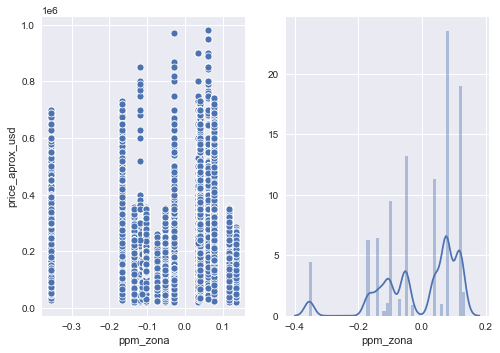

In [152]:
f, (ax0, ax1) = plt.subplots(1, 2)
sns.scatterplot(x='ppm_zona', y='price_aprox_usd', data=gba_data, ax=ax0)
sns.distplot(gba_data['ppm_zona'], ax=ax1)

Correlación entre las nuevas *features* agregadas.

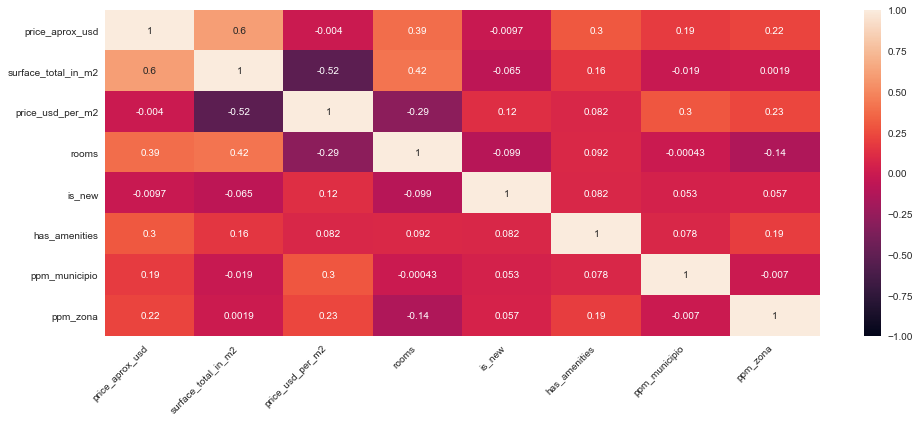

In [153]:
correlation_df(gba_data[['price_aprox_usd', 'surface_total_in_m2', 'price_usd_per_m2', 'rooms', 'is_new', 'has_amenities', 'ppm_municipio', 'ppm_zona']])

#### TODOS

- Todos los property types en simultáneo.

C:\Users\herna\miniconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 138924730673092.42, tolerance: 50987286619.98416
  positive)


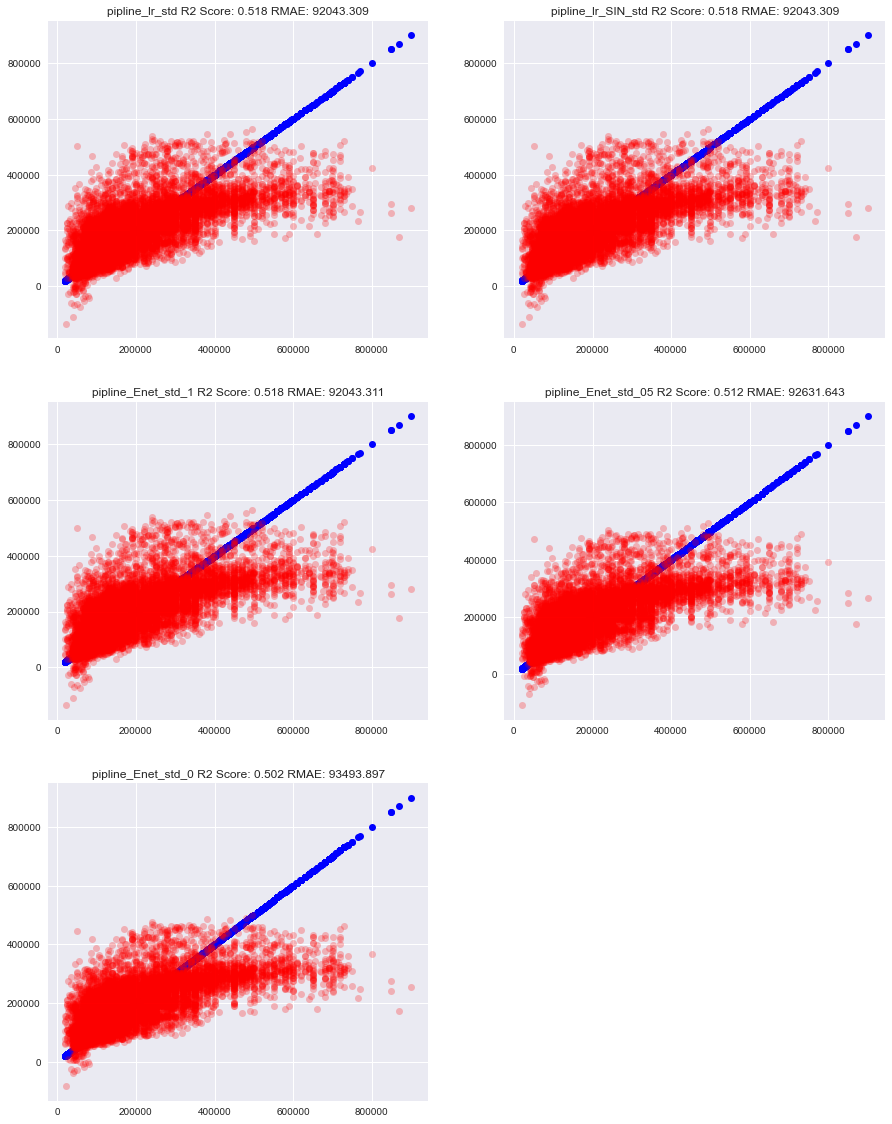

In [154]:
# filtrar datos.
gba_eval_df = gba_data.copy()
gba_eval_df = pd.get_dummies(data=gba_data, columns=['property_type'], drop_first=True)
gba_eval_df['rooms'] = gba_eval_df['rooms'].apply(lambda x: 2 if np.isnan(x) else x)
gba_eval_df = gba_eval_df.dropna()

# variables explicativas.
features = ['property_type_apartment', 'property_type_house', 'property_type_store', 
            'ppm_zona', 'ppm_municipio', 'surface_total_in_m2', 'rooms', 'has_amenities', 'is_new']

# variable a predecir.
label = ['price_aprox_usd']

# pipeline de modelos.
entrenar_plotear(
    gba_eval_df[features], 
    gba_eval_df[label],
    alpha=0.25
)

EMC: 8176622298.440379
R2: 0.5244016203426176


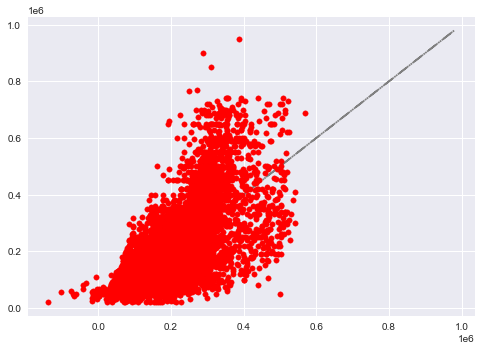

In [155]:
model, predictions = entrenar(gba_eval_df[features], gba_eval_df[label], True)

In [156]:
cv = cross_validate(model, X, y, cv=20)
print (f"El cross validation con 20 iteraciones da: {cv['test_score'].mean()}")

El cross validation con 20 iteraciones da: 0.3901993975460889


#### PH

C:\Users\herna\miniconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1210950011054.74, tolerance: 357115528.2924999
  positive)


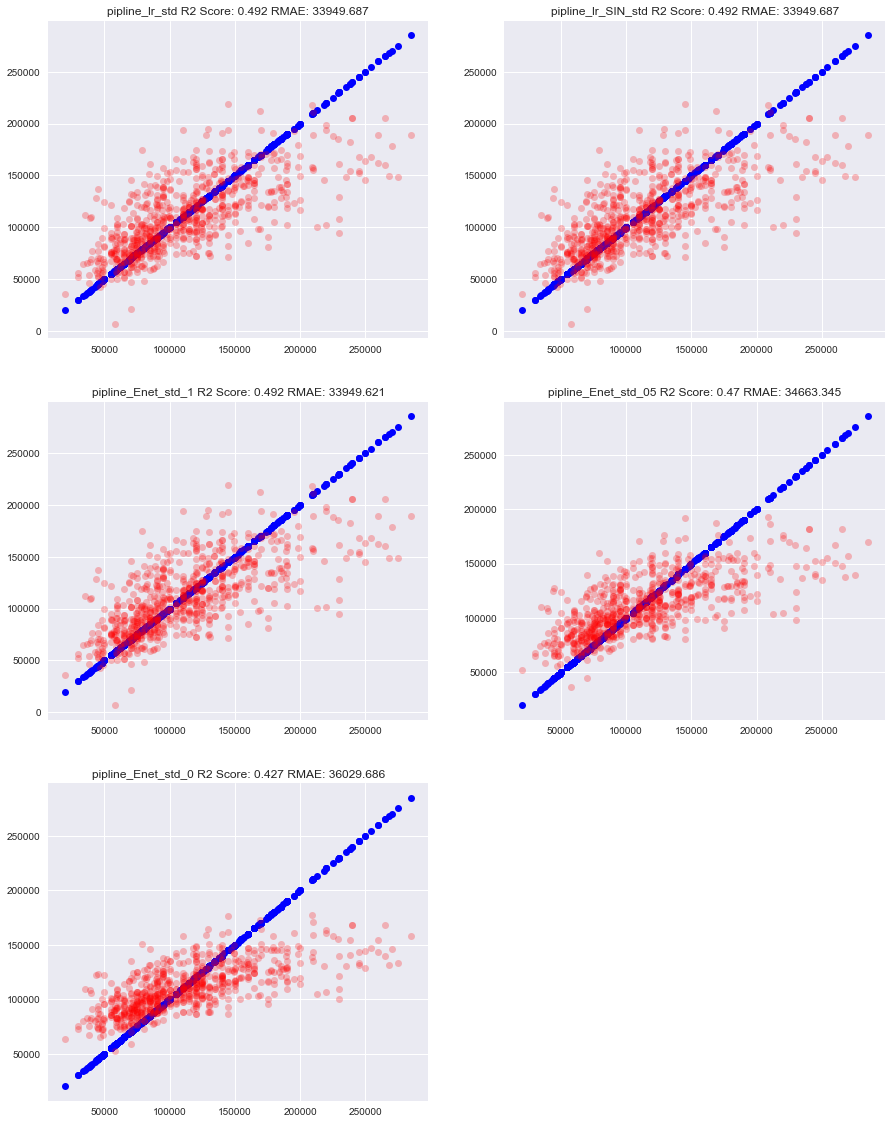

In [157]:
# filtrar datos.
gba_eval_df = gba_data.copy().loc[gba_data['property_type'] == 'PH']
gba_eval_df['rooms'] = gba_eval_df['rooms'].apply(lambda x: 4 if np.isnan(x) else x)
gba_eval_df = gba_eval_df.dropna()

# variables explicativas.
features = ['ppm_zona', 'ppm_municipio', 'surface_total_in_m2', 'rooms', 'has_amenities', 'is_new']

# variable a predecir.
label = ['price_aprox_usd']

# pipeline de modelos.
entrenar_plotear(
    gba_eval_df[features], 
    gba_eval_df[label],
    alpha=0.75
)

EMC: 1060660200.6403601
R2: 0.5129857391945898


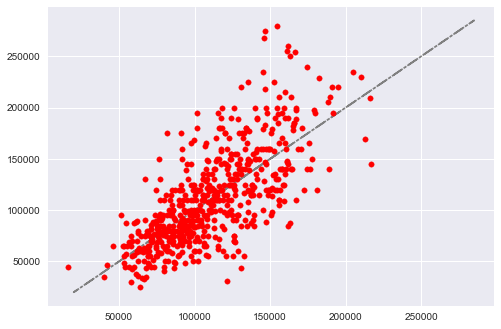

In [158]:
model, predictions = entrenar(gba_eval_df[features], gba_eval_df[label], True)

In [159]:
cv = cross_validate(model, gba_eval_df[features], gba_eval_df[label], cv=20)
print (f"El cross validation con 20 iteraciones da: {cv['test_score'].mean()}")

El cross validation con 20 iteraciones da: 0.48652952410708367


#### STORE

C:\Users\herna\miniconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8620705133713.883, tolerance: 2341716789.1190968
  positive)


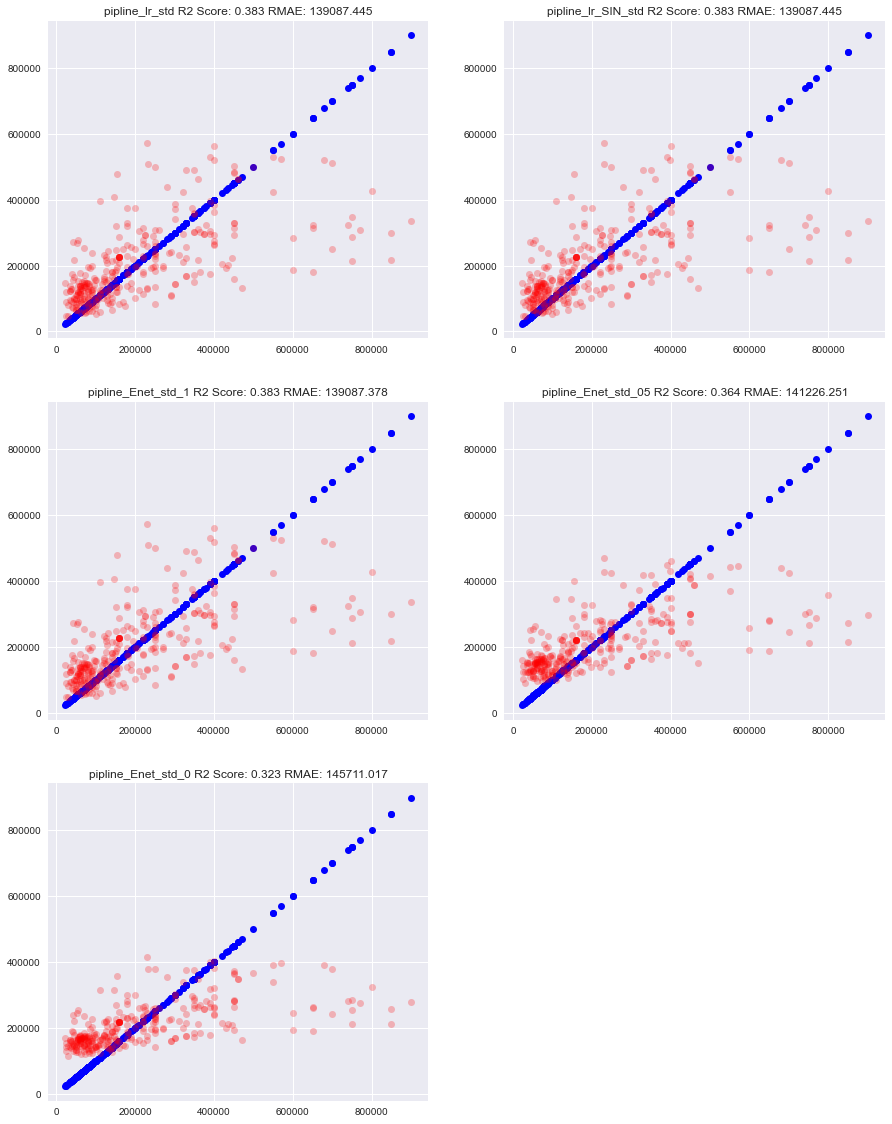

In [160]:
# filtrar datos.
gba_eval_df = gba_data.copy().loc[gba_data['property_type'] == 'store']
gba_eval_df['rooms'] = gba_eval_df['rooms'].apply(lambda x: 4 if np.isnan(x) else x)
gba_eval_df = gba_eval_df.dropna()

# variables explicativas.
features = ['ppm_zona', 'ppm_municipio', 'surface_total_in_m2', 'rooms', 'has_amenities', 'is_new']

# variable a predecir.
label = ['price_aprox_usd']

entrenar_plotear(
    gba_eval_df[features], 
    gba_eval_df[label],
    alpha=0.75
)

EMC: 22393698624.612602
R2: 0.4447809517118756


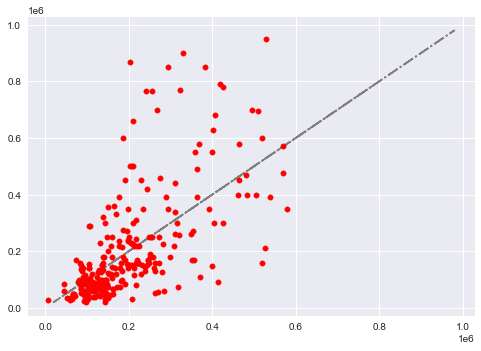

In [161]:
model, predictions = entrenar(gba_eval_df[features], gba_eval_df[label], True)

In [162]:
cv = cross_validate(model, gba_eval_df[features], gba_eval_df[label], cv=20)
print (f"El cross validation con 20 iteraciones da: {cv['test_score'].mean()}")

El cross validation con 20 iteraciones da: 0.39232060200659313


#### HOUSE

C:\Users\herna\miniconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109496957690785.25, tolerance: 27785009786.275295
  positive)


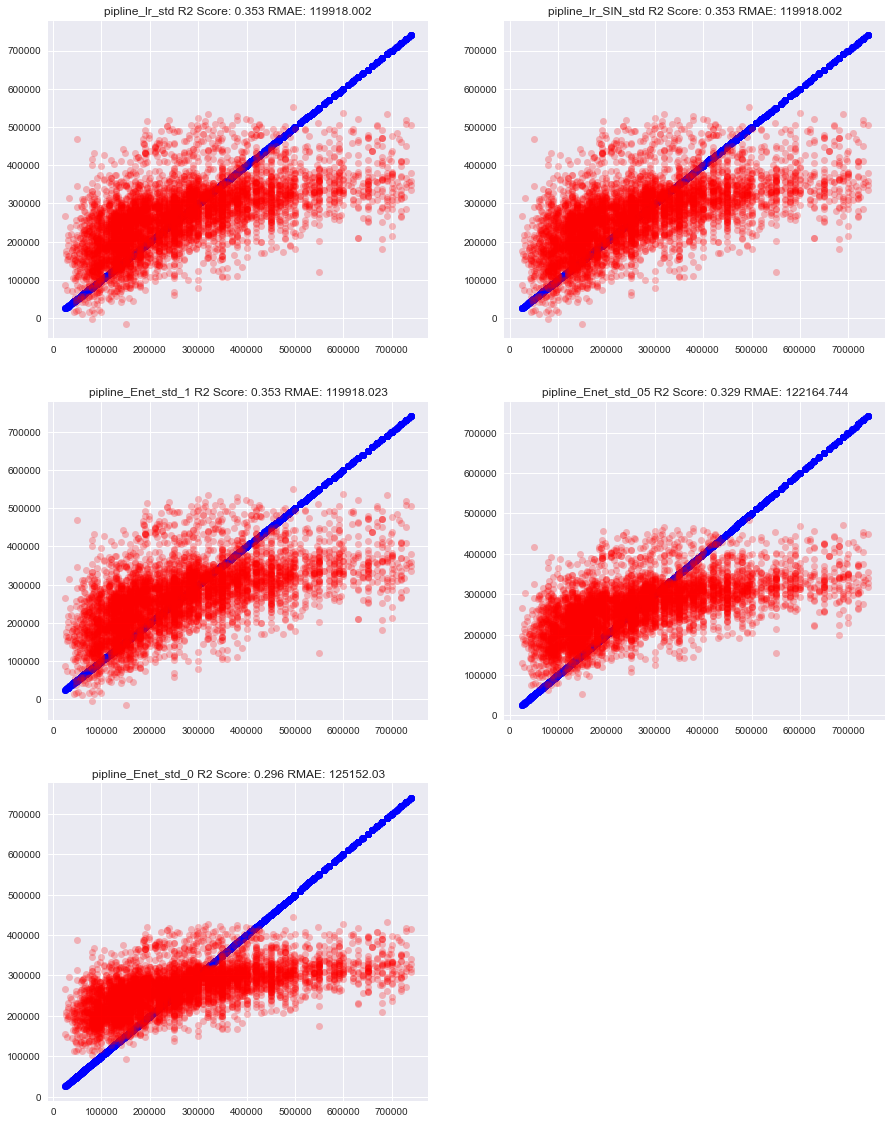

In [163]:
# filtrar datos.
gba_eval_df = gba_data.copy().loc[gba_data['property_type'] == 'house']
gba_eval_df['rooms'] = gba_eval_df['rooms'].apply(lambda x: 4 if np.isnan(x) else x)
gba_eval_df = gba_eval_df.dropna()

# variables explicativas.
features = ['ppm_zona', 'ppm_municipio', 'surface_total_in_m2', 'rooms', 'has_amenities', 'is_new']

# variable a predecir.
label = ['price_aprox_usd']

# pipe line de modelos.
entrenar_plotear(
    gba_eval_df[features], 
    gba_eval_df[label],
    alpha=0.75
)

EMC: 14427727758.738201
R2: 0.34620540572500236


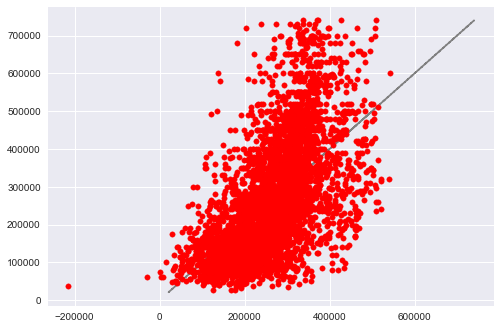

In [164]:
model, predictions = entrenar(gba_eval_df[features], gba_eval_df[label], True)

In [165]:
cv = cross_validate(model, gba_eval_df[features], gba_eval_df[label], cv=20)
print (f"El cross validation con 20 iteraciones da: {cv['test_score'].mean()}")

El cross validation con 20 iteraciones da: 0.33431770641544517


#### APARTMENT

C:\Users\herna\miniconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16872705708856.484, tolerance: 6009462999.703665
  positive)


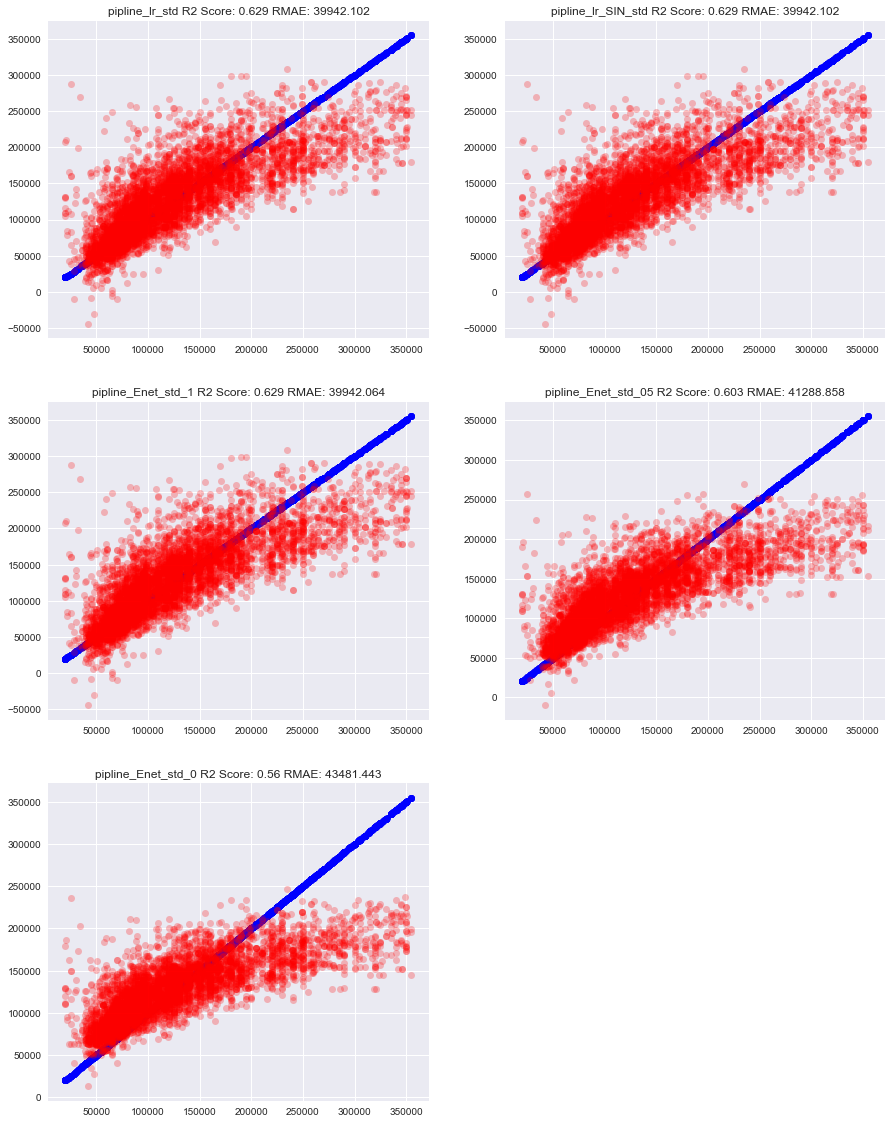

In [166]:
# filtrar datos.
gba_eval_df = gba_data.loc[gba_data['property_type'] == 'apartment']
gba_eval_df['rooms'] = gba_eval_df['rooms'].apply(lambda x: 2 if np.isnan(x) else x)
gba_eval_df = gba_eval_df.dropna()

# variables explicativas.
features = ['ppm_zona', 'ppm_municipio', 'surface_total_in_m2', 'rooms', 'has_amenities']

# variables a predecir.
label = ['price_aprox_usd']

# pipeline de modelos.
entrenar_plotear(
    gba_eval_df[features], 
    gba_eval_df[label],
    alpha=0.75
)

EMC: 1490095104.0364437
R2: 0.6490685983958813


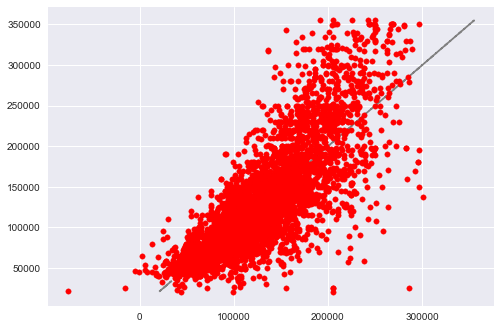

In [167]:
model, predictions = entrenar(gba_eval_df[features], gba_eval_df[label], True)

In [168]:
cv = cross_validate(model, gba_eval_df[features], gba_eval_df[label], cv=20)
print (f"El cross validation con 20 iteraciones da: {cv['test_score'].mean()}")

El cross validation con 20 iteraciones da: 0.6382800726527913
